In [45]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,8
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [46]:
def Creat_Model():
    model = {
        "Dense1":Dense(100,activation='tanh'),
        'Dense2':Dense(100,activation='tanh'),
        "Dense3":Dense(50,activation='tanh'),
        'Output':Dense(units=1,activation='sigmoid')
    }
    return model

In [47]:
def Call_Model(model,X):
    X = model['Dense1'](X)
    X = model['Dense2'](X)
    X = model['Dense3'](X)
    X = model['Output'](X)

    return X
    

In [48]:
def PDE(X,model):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        y_pred = Call_Model(model,X)
        y_X = tape.gradient(y_pred,X)
        y_XX = tape.gradient(y_X,X)

        del tape

        return y_XX + np.pi**2 * tf.sin(np.pi * X)
        # return u_t + velocity[0] * u_x + velocity[1] * u_y - D * (u_xx + u_yy)

In [49]:
def Loss_Function(model,X,X_bc,y_bc):
    residuals = PDE(X,model)
    loss_PDE = tf.reduce_mean(tf.square(residuals))
    y_bc_pred = Call_Model(model,X_bc)
    loss_bc = tf.reduce_mean(tf.square(y_bc - y_bc_pred))

    return loss_PDE + loss_bc

In [50]:
def Train_Step(model,X,X_bc,y_bc,optimizer):
    with tf.GradientTape() as tape:
        loss_value = Loss_Function(model,X,X_bc,y_bc)
    gradiants = tape.gradient(loss_value,[layer.trainable_variables for layer in model.values()])
    gradiants = [grads for sublist in gradiants for grads in sublist]
    variables = [var for layer in model.values() for var in layer.trainable_variables]
    optimizer.apply_gradients(zip(gradiants,variables))

    return loss_value

In [51]:
X_train = np.linspace(-1,1,100).reshape(-1,1)
X_train = tf.convert_to_tensor(X_train,dtype=tf.float32)

X_bc = np.array([[-1.0],[2.0]],dtype=np.float32)
X_bc = tf.convert_to_tensor(X_bc,dtype=tf.float32)

y_bc = np.array([[0.0],[1.0]],dtype=np.float32)
y_bc = tf.convert_to_tensor(y_bc,dtype=tf.float32)



In [52]:
model = Creat_Model()
scheduler = ExponentialDecay(initial_learning_rate=1e-5,
                             decay_steps = 1000,
                             decay_rate = 1.5)
optimizer = Adam(learning_rate=scheduler)

In [53]:
epoches = 500
for epoch in range(epoches):
    loss_value = Train_Step(model,X_train,X_bc,y_bc,optimizer)
    if epoch %10 ==0 & epoch %1000 ==0:
        print(f"Epoch: {epoch} loss: {loss_value.numpy()}")

Epoch: 0 loss: 49.20011901855469
Epoch: 10 loss: 49.16952896118164
Epoch: 20 loss: 49.13814163208008
Epoch: 30 loss: 49.10575485229492
Epoch: 40 loss: 49.07218551635742
Epoch: 50 loss: 49.03720474243164
Epoch: 60 loss: 49.000614166259766
Epoch: 70 loss: 48.96218490600586
Epoch: 80 loss: 48.921669006347656
Epoch: 90 loss: 48.87879943847656
Epoch: 100 loss: 48.833274841308594
Epoch: 110 loss: 48.78477096557617
Epoch: 120 loss: 48.732933044433594
Epoch: 130 loss: 48.6773567199707
Epoch: 140 loss: 48.61760330200195
Epoch: 150 loss: 48.553199768066406
Epoch: 160 loss: 48.483612060546875
Epoch: 170 loss: 48.40827941894531
Epoch: 180 loss: 48.326595306396484
Epoch: 190 loss: 48.237918853759766
Epoch: 200 loss: 48.14158248901367
Epoch: 210 loss: 48.03692626953125
Epoch: 220 loss: 47.92325973510742
Epoch: 230 loss: 47.799922943115234
Epoch: 240 loss: 47.66627502441406
Epoch: 250 loss: 47.521724700927734
Epoch: 260 loss: 47.36573791503906
Epoch: 270 loss: 47.19782638549805
Epoch: 280 loss: 47.01

In [54]:
X_test = np.linspace(-1,1,1000).reshape(-1,1)
X_test = tf.convert_to_tensor(X_test,dtype=tf.float32)

y_pred = Call_Model(model,X_test).numpy()
y_true = np.sin(np.pi * X_test)

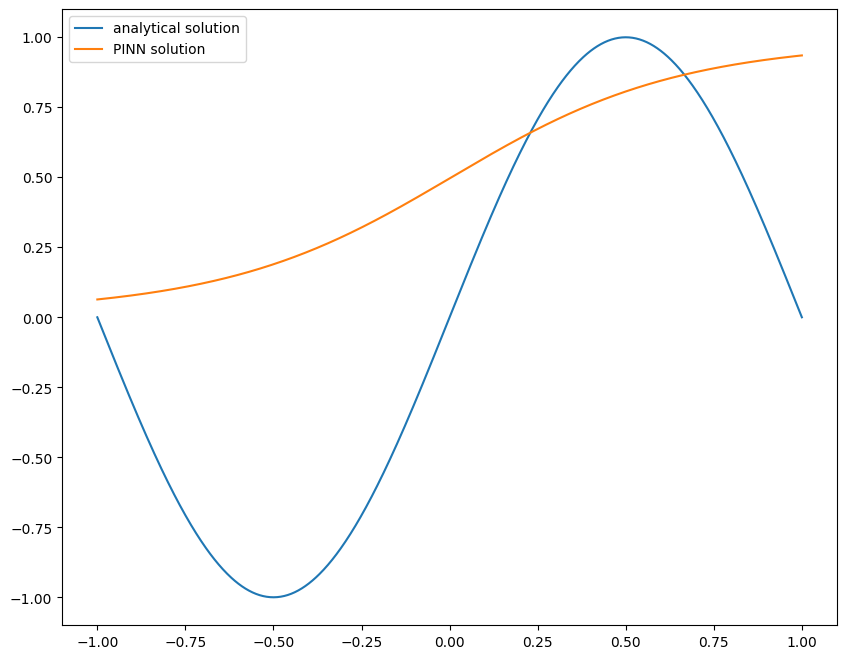

In [55]:
plt.plot(X_test,y_true, label = 'analytical solution')
plt.plot(X_test,y_pred, label = 'PINN solution')
plt.legend()
plt.show()